# MURaM Chromosphere

In this notebook we look at some of the properties of the MURaM chromosphere.

In [1]:
import muram
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
os.getpid() # for checking memory/CPU in terminal

205552

In [3]:
# Set the location of the MURaM data
dir2D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/2D"
dir3D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/3D"
iteration = 12000

## Mean Atmosphere

Below we compute the horizontally averaged atmosphere, in order to compare it to the standard FALC atmosphere.

Note: this goes over a lot of data and is slow.  An ugly, dirty trick is done to keep this procedure within memory limits.

In [4]:
snap = muram.MuramSnap(dir3D, iteration)

# Build a height axis with 0 == tau1
x = np.arange(snap.T.shape[0]) * 16. # km
tau = np.mean(snap.tau, axis=(1,2))
tau1_ix = (np.abs(tau - 1.0)).argmin()
height = x - x[tau1_ix]

snap = muram.MuramSnap(dir3D, iteration) # reinitialize to save memory

In [5]:
dh = 16.
plot_heights = np.arange(0, height.max() + dh, dh)
print("N heights:", len(plot_heights))

N heights: 125


In [6]:
size_ixs = snap.shape
size_Mm = snap.shape * snap.dX / 1e8 # Mm
AU = 1.496e+5 # Mm
size_deg = np.degrees(np.arctan(size_Mm/AU)) # deg
size_as = size_deg * 3600 # arcsec
print("Domain size [ixs]", size_ixs)
print("Domain size [Mm]", size_Mm)
print("Domain size [deg]", size_deg)
print("Domain size [as]", size_as)

Domain size [ixs] [ 512 1536 1536]
Domain size [Mm] [ 8.192 24.576 24.576]
Domain size [deg] [0.00313748 0.00941244 0.00941244]
Domain size [as] [11.29492842 33.88478498 33.88478498]


In [7]:
dX_as = np.degrees(np.arctan(16/1e3/AU)) * 3600 # arcsec
dX_as

0.022060407085250863

In [8]:
AU * np.tan(np.radians(0.5 / 3600)) * 1e3 # km

362.64063347064325

In [9]:
mpl.rcParams.update({'font.size': 22})

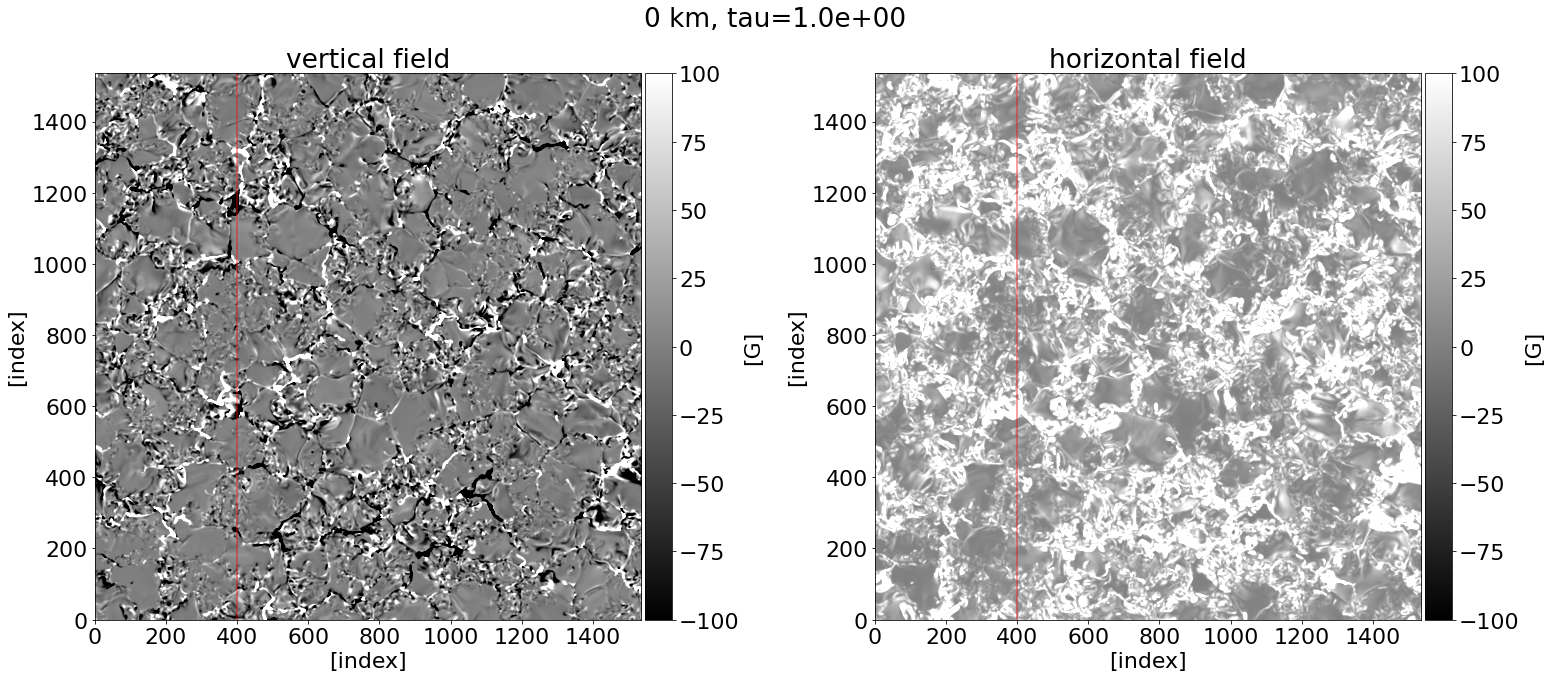

In [10]:
def plot_x(x, mag_thresh = 100., save=False, close=False, spatial=None, ylines=None, zlines=None):
    if spatial is None:
        spatial_label = '[index]'
        extent = None
    elif spatial == 'as':
        extent = (0, size_as[1], 0, size_as[2])
        spatial_label = '[arcsec]'
    elif spatial == 'Mm':
        extent = (0, size_Mm[1], 0, size_Mm[2])
        spatial_label = '[Mm]'
    else:
        raise Exception("Unsupported spatial option")

    h = height[x]
    imparams = dict(origin='lower', interpolation='bicubic', extent=extent)
    sequential = dict(**imparams, cmap='inferno')
    diverging = dict(**imparams, cmap='seismic_r')
    magnetogram = dict(**imparams, cmap='gray', vmin=-mag_thresh, vmax=+mag_thresh)
    hor_magnetogram = dict(**imparams, cmap='gray', vmin=0, vmax=+mag_thresh)
    figsize = (22,10)

    t = tau[x]
    Bver = snap.Bx[x,:,:] * np.sqrt(4*np.pi)
    Bhor = np.sqrt(snap.By[x,:,:]**2 + snap.Bz[x,:,:]**2) * np.sqrt(4*np.pi)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    im1 = ax1.imshow(Bver, **magnetogram)
    im2 = ax2.imshow(Bhor, **magnetogram)
    for (im, ax) in ((im1, ax1), (im2, ax2)):
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, label="[G]")
    
    linestyle = dict(ls='-', c='r', alpha=0.5)
    if ylines is not None:
        for y in ylines:
            ax1.axvline(y, **linestyle)
            ax2.axvline(y, **linestyle)
    if zlines is not None:
        for z in zlines:
            ax1.axhline(y, **linestyle)
            ax2.axhline(y, **linestyle)

    for ax in (ax1, ax2):
        ax.set_xlabel(spatial_label)
        ax.set_ylabel(spatial_label)
    ax1.set_title("vertical field")
    ax2.set_title("horizontal field")
        
    fig.suptitle(f"{h:0.0f} km, tau={t:0.1e}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        filename = f"field_{h:04.0f}km.png"
        print(filename)
        fig.savefig(filename, bbox_inches='tight')
    if close:
        plt.close(fig)

for h in plot_heights[0:1]:
    x = np.where(height == h)[0][0]
    plot_x(x, ylines=[400,])
    #plot_x(x, save=True, close=True)

In [11]:
def pick_x(h):
    x = (np.abs(height - h)).argmin()
    h_actual = height[x]
    return x, h_actual

h0 = 0.
x0, h0 = pick_x(h0)
B0 = snap.Bx[x0,:,:] * np.sqrt(4 * np.pi)

B0_mean = np.mean(B0)
B0_min = np.min(B0)
B0_max = np.max(B0)
print(f"h={h0} x={x0} Bx mean={B0_mean:0.1f} min={B0_min:+0.1f} max={B0_max:+0.1f}")

h = 1600.
x, h = pick_x(h)
Bx = snap.Bx[x,:,:] * np.sqrt(4 * np.pi)

Bx_mean = np.mean(Bx)
Bx_min = np.min(Bx)
Bx_max = np.max(Bx)
print(f"h={h} x={x} Bx mean={Bx_mean:0.1f} min={Bx_min:+0.1f} max={Bx_max:+0.1f}")

h=0.0 x=387 Bx mean=-0.0 min=-1826.7 max=+1516.5
h=1600.0 x=487 Bx mean=-0.0 min=-40.7 max=+49.6


In [12]:
ix_step = 23
dX_as * ix_step

0.5073893629607699

N points 67


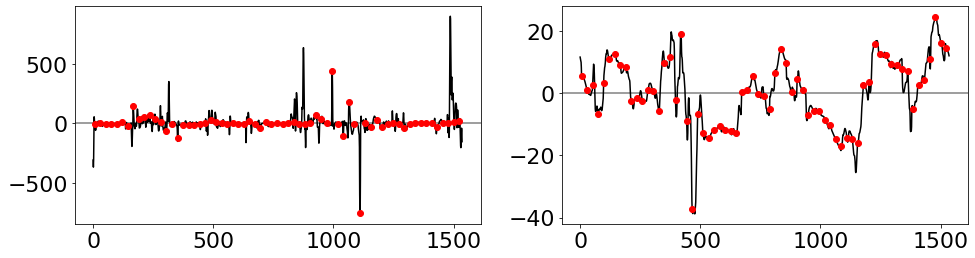

In [13]:
y = 450
z = np.arange(6, size_ixs[1]+1, ix_step)
print('N points', len(z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.axhline(c='gray')
ax1.plot(B0[y,:], 'k-')
B0i = B0[y, z]
ax1.plot(z, B0i, 'ro')

ax2.axhline(c='gray')
ax2.plot(Bx[y,:], 'k-')
Bxi = Bx[y, z]
ax2.plot(z, Bxi, 'ro')

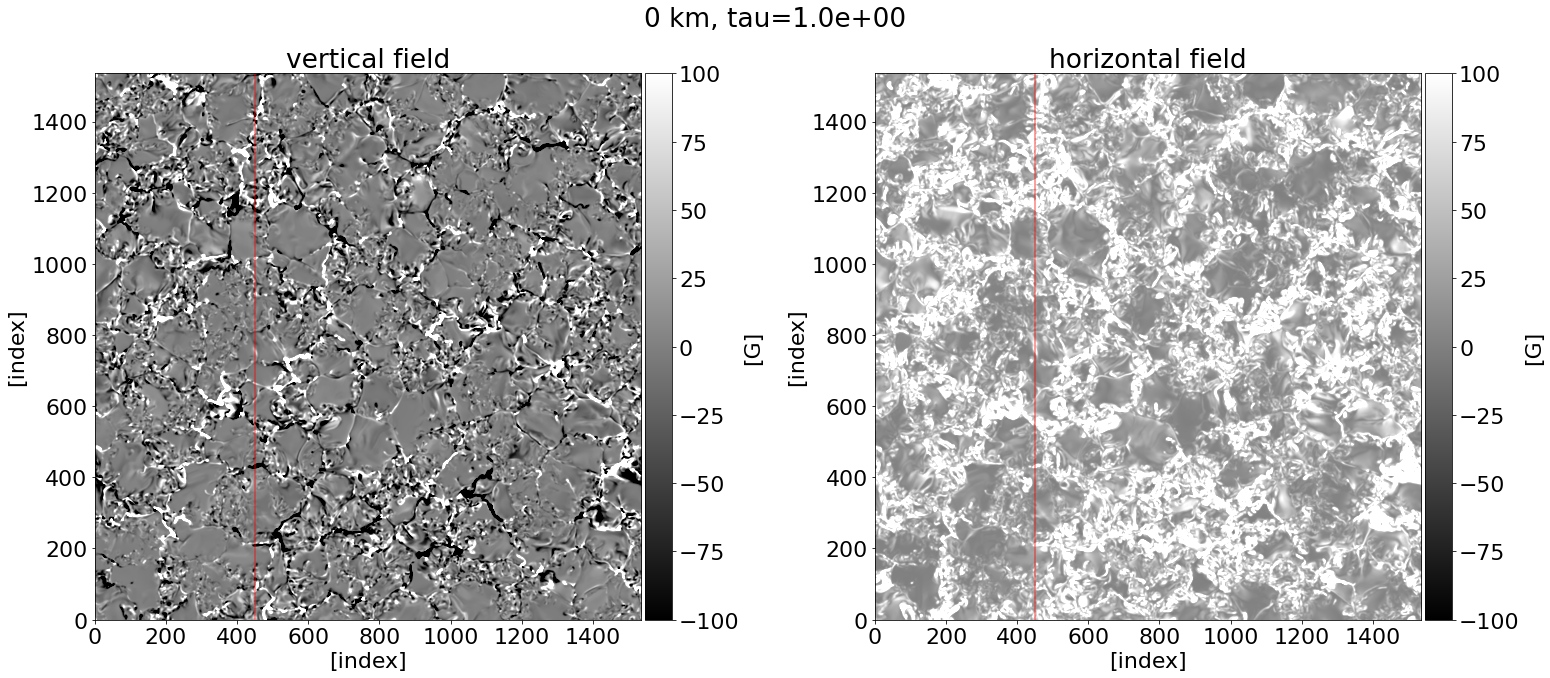

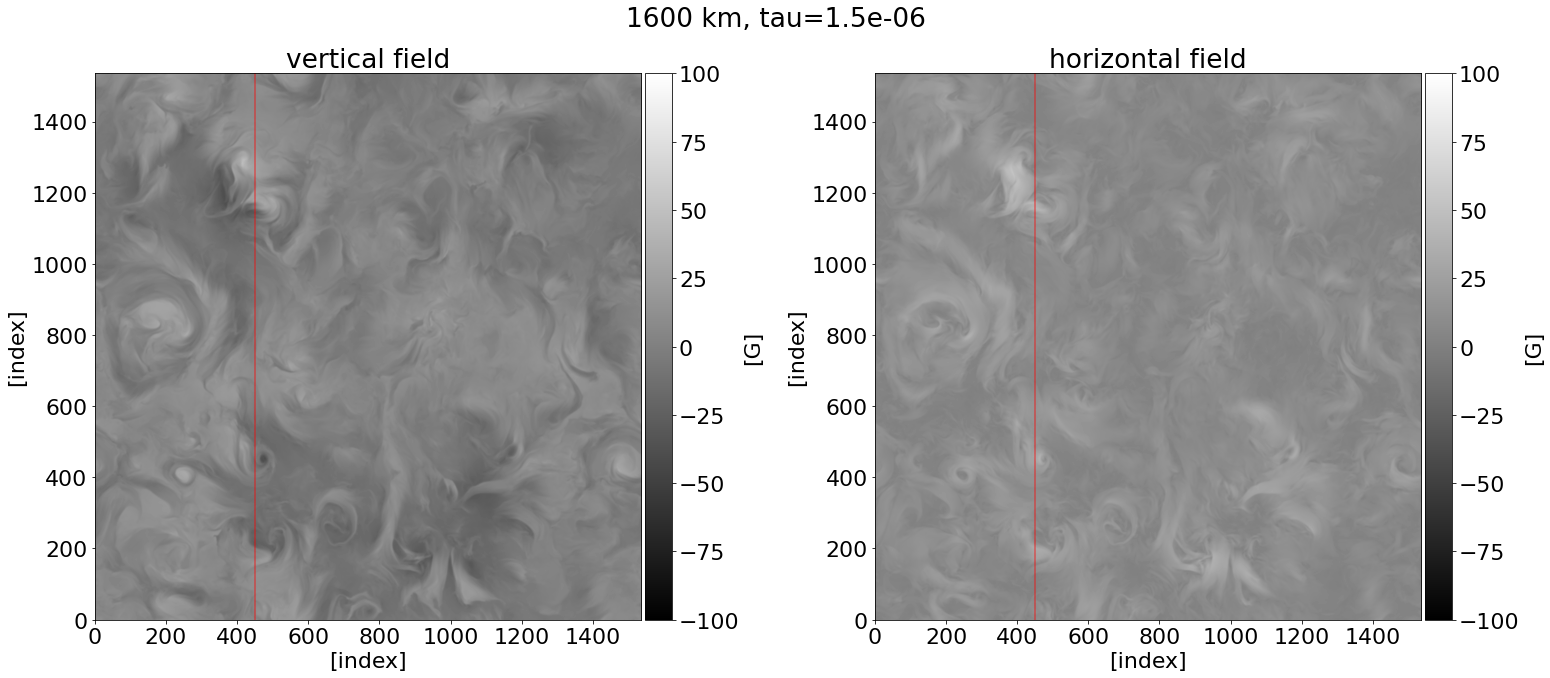

In [14]:
plot_x(x0, ylines=[y,])
plot_x(x, ylines=[y,])

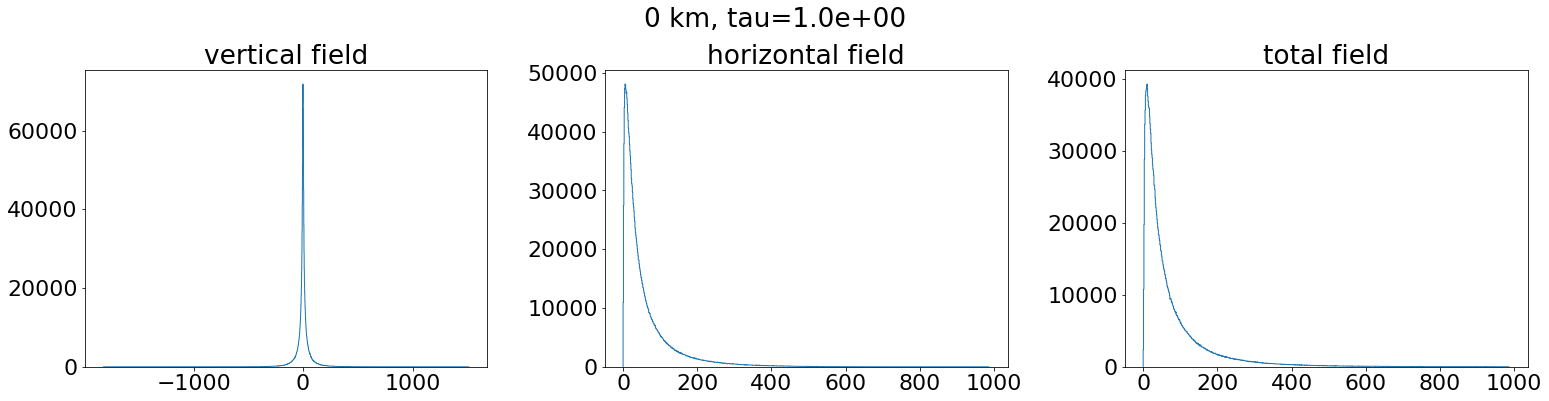

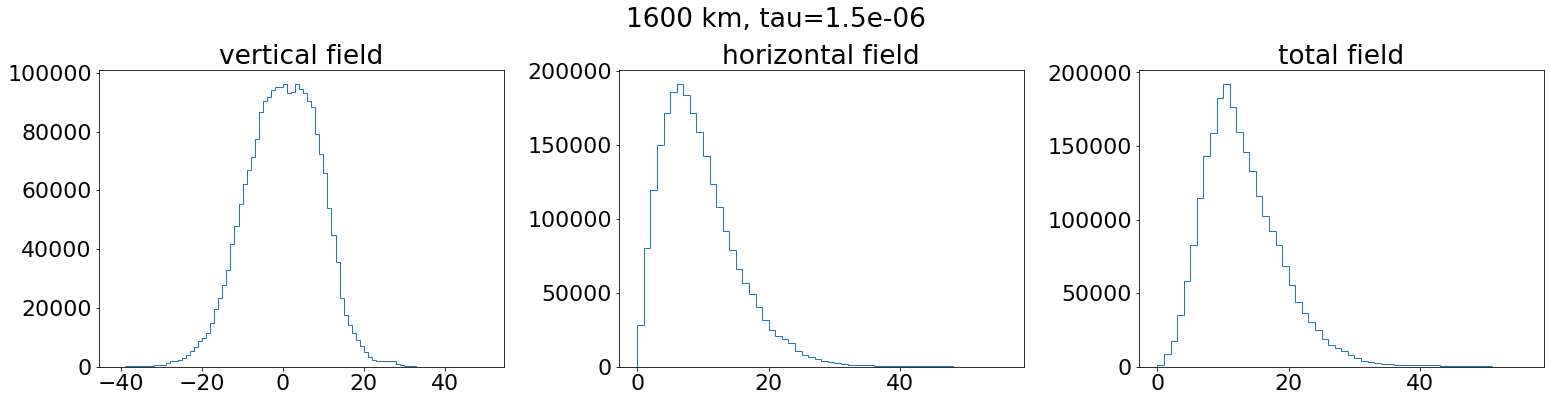

In [15]:
def hist_x(x, binw=1., save=False, close=False):
    h = height[x]
    figsize = (22,6)

    t = tau[x]
    Bver = snap.Bx[x,:,:] * np.sqrt(4*np.pi)
    Bhor = np.sqrt(snap.By[x,:,:]**2 + snap.Bz[x,:,:]**2) * np.sqrt(4*np.pi)
    B = np.sqrt(snap.Bx[x,:,:]**2 + snap.By[x,:,:]**2 + snap.Bz[x,:,:]**2) * np.sqrt(4*np.pi)

    bins_ver = np.arange(np.floor(np.min(Bver)/binw) * binw, np.max(Bver) + binw, binw)
    bins_hor = np.arange(0., np.max(Bhor) + binw, binw)
    bins_B = np.arange(0., np.max(B) + binw, binw)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    ax1.hist(Bver.flatten(), bins_ver, histtype='step')
    ax2.hist(Bhor.flatten(), bins_hor, histtype='step')
    ax3.hist(B.flatten(), bins_hor, histtype='step')

    ax1.set_title("vertical field")
    ax2.set_title("horizontal field")
    ax3.set_title("total field")

    fig.suptitle(f"{h:0.0f} km, tau={t:0.1e}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        filename = f"hist_{h:04.0f}km.png"
        print(filename)
        fig.savefig(filename, bbox_inches='tight')
    if close:
        plt.close(fig)
        
hist_x(x0)
hist_x(x)

In [49]:
Bver = snap.Bx[x,:,:] * np.sqrt(4*np.pi)
Bhor = np.sqrt(snap.By[x,:,:]**2 + snap.Bz[x,:,:]**2) * np.sqrt(4*np.pi)
B = np.sqrt(snap.Bx[x,:,:]**2 + snap.By[x,:,:]**2 + snap.Bz[x,:,:]**2) * np.sqrt(4*np.pi)

sel_lo = B < 10.
sel_med = (B >= 10.) & (B < 20.)
sel_hi = B >= 20.

print(f"pixel selections: lo={sel_lo.sum()} med={sel_med.sum()} hi={sel_hi.sum()}")
B_mean_lo = np.mean(B[sel_lo])
B_mean_med = np.mean(B[sel_med])
B_mean_hi = np.mean(B[sel_hi])
print(f"selection means: lo={B_mean_lo:0.1f} med={B_mean_med:0.1f} hi={B_mean_hi:0.1f}")

pixel selections: lo=802804 med=1269358 hi=287134
selection means: lo=7.2 med=14.1 hi=24.7


In [57]:
ntop = snap.shape[0] # n indexes from x0 to the top
sel = np.array([sel_lo] * ntop)

In [73]:
Bxsq = np.power(np.ma.array(snap.Bx * np.sqrt(4*np.pi), mask=sel), 2)

In [87]:
Bxsq = np.power(snap.Bx[:,sel_lo] * np.sqrt(4*np.pi), 2)

In [94]:
Bver2 = np.mean(np.sqrt(Bxsq), axis=1)

In [95]:
x2 = height[x0:] == h
Bver2[x]

4.0982814

In [76]:
np.mean(np.sqrt(np.power(snap.Bx[x,:,:][sel_lo] * np.sqrt(4*np.pi), 2)))

4.0984135

In [98]:
def calc_mean_field(x0, sel):
    snap = muram.MuramSnap(dir3D, iteration) # local copy to save memory
    ntop = (snap.shape[0] - x0) # n indexes from x0 to the top
    #sel = np.array( [sel] * ntop) # 2D => 3D boolean array
    
    Bxsq = np.power(snap.Bx[x0:,sel] * np.sqrt(4*np.pi), 2)
    #Bxsq = np.power(np.ma.array(snap.Bx[x0:,:,:], mask=sel) * np.sqrt(4*np.pi), 2)
    delattr(snap, 'Bx')

    Bysq = np.power(snap.By[x0:,sel] * np.sqrt(4*np.pi), 2)
    #Bysq = np.power(np.ma.array(snap.By[x0:,:,:], mask=sel) * np.sqrt(4*np.pi), 2)
    delattr(snap, 'By')

    Bzsq = np.power(snap.Bz[x0:,sel] * np.sqrt(4*np.pi), 2)
    #Bzsq = np.power(np.ma.array(snap.Bz[x0:,:,:], mask=sel) * np.sqrt(4*np.pi), 2)
    delattr(snap, 'Bz')
    
    Bver = np.mean(np.sqrt(Bxsq), axis=1)
    Bhor = np.mean(np.sqrt(Bysq + Bzsq), axis=1)
    B = np.mean(np.sqrt(Bxsq + Bysq + Bzsq), axis=1)
    
    return Bver, Bhor, B

Bver_hi, Bhor_hi, B_hi = calc_mean_field(x0, sel_hi)
Bver_med, Bhor_med, B_med = calc_mean_field(x0, sel_med)
Bver_lo, Bhor_lo, B_lo = calc_mean_field(x0, sel_lo)

In [104]:
# Sanity check
x2 = height[x0:] == h
B_h_lo = B_lo[x2][0]
B_h_med = B_med[x2][0]
B_h_hi = B_hi[x2][0]
print(f"selection means (1): lo={B_mean_lo:0.1f} med={B_mean_med:0.1f} hi={B_mean_hi:0.1f}")
print(f"selection means (2): lo={B_h_lo:0.1f} med={B_h_med:0.1f} hi={B_h_hi:0.1f}")

selection means (1): lo=7.2 med=14.1 hi=24.7
selection means (2): lo=7.2 med=14.1 hi=24.7


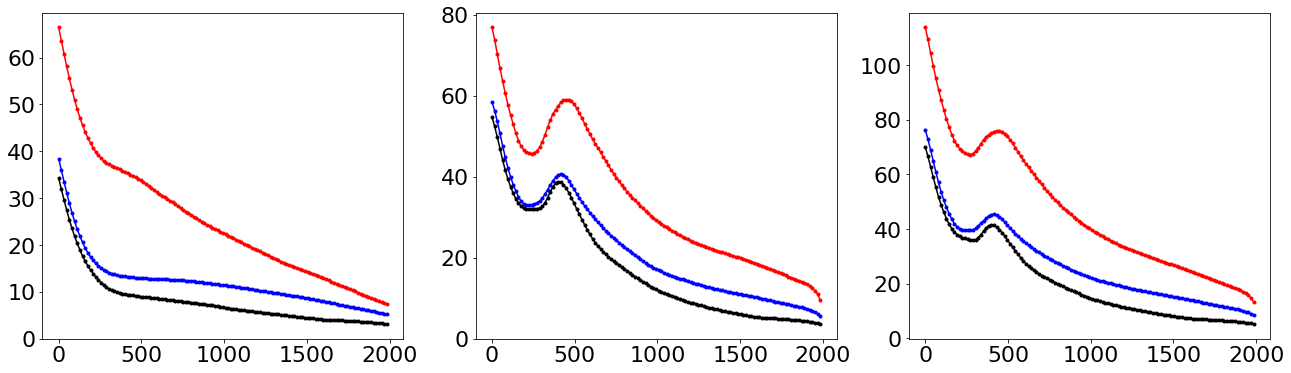

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,6))
ax1.plot(height[x0:], Bver_hi,  'r.-')
ax2.plot(height[x0:], Bhor_hi,  'r.-')
ax3.plot(height[x0:], B_hi,  'r.-')

ax1.plot(height[x0:], Bver_med, 'b.-')
ax2.plot(height[x0:], Bhor_med, 'b.-')
ax3.plot(height[x0:], B_med,  'b.-')

ax1.plot(height[x0:], Bver_lo,  'k.-')
ax2.plot(height[x0:], Bhor_lo,  'k.-')
ax3.plot(height[x0:], B_lo,  'k.-')`b

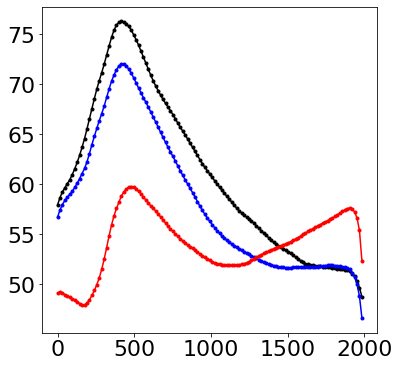

In [108]:
inc_lo = np.degrees(np.arctan2(Bhor_lo, Bver_lo))
inc_med = np.degrees(np.arctan2(Bhor_med, Bver_med))
inc_hi = np.degrees(np.arctan2(Bhor_hi, Bver_hi))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(height[x0:], inc_lo, 'k.-')
ax.plot(height[x0:], inc_med, 'b.-')
ax.plot(height[x0:], inc_hi, 'r.-')